## General imports

In [9]:
import os
import pickle
import numpy as np

from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Tensorflow imports

In [10]:
import tensorflow as tf

# silencing tensorflow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

tf.__version__ # printint out tensorflow version used

'1.15.0'

## Stable-Baselines import

In [11]:
import stable_baselines
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import TRPO
from stable_baselines.bench import Monitor
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import results_plotter
stable_baselines.__version__ # printing out stable_baselines version used

'2.10.1'

## Environment imports

In [12]:
import gym

## Callback function

In [13]:
# callback from https://stable-baselines.readthedocs.io/en/master/guide/examples.html#using-callback-monitoring-training
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps), end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

## Environment setting

In [14]:
# loading the topology binary file containing the graph and the k-shortest paths
topology_name = 'nsfnet_eon'
k_paths = 5
with open(f'topologies/{topology_name}_{k_paths}-paths.h5', 'rb') as f:
    topology = pickle.load(f)

# node probabilities from https://github.com/xiaoliangchenUCD/DeepRMSA/blob/6708e9a023df1ec05bfdc77804b6829e33cacfe4/Deep_RMSA_A3C.py#L77
node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
       0.07607608, 0.12012012, 0.01901902, 0.16916917])

# Scenario to run: 1=Band C, 2=Bands C+L, 3=Bands C+L+S, 4=Bands C+L+S+E
scenario=3
            
env_args = dict(scenario=scenario, load=1000, topology=topology, seed=10, #load is for traffic load
                allow_rejection=False, # the agent cannot proactively reject a request
                j=1, # consider only the first suitable spectrum block for the spectrum assignment
                mean_service_holding_time=200, # value is not set as in the paper to achieve comparable reward values
                #num_spectrum_resources=num_spectrum_resources,
                episode_length=50, node_request_probabilities=None)

## Creating monitors and agent

In [15]:
# Create log dir
log_dir = "./tmp/deeptest-trpo/"     # logs will be saved in log_dir/training.monitor.csv
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)

env = gym.make('DeepRBMLSA-v0', **env_args)
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor
env = Monitor(env, log_dir + 'training', info_keywords=('service_blocking_rate_since_reset','bit_rate_blocking_rate_since_reset'))

# here goes the arguments of the policy network to be used
policy_args = dict(net_arch=5*[128], # the neural network has five layers with 128 neurons each
                   act_fun=tf.nn.elu)    # we use the elu activation function

agent = TRPO(MlpPolicy, env, verbose=0, tensorboard_log="./tb/TRPO-DeepRBMLSA-v0/", policy_kwargs=policy_args, gamma=.95)

## Training the agent

In [16]:
a = agent.learn(total_timesteps=100000, callback=callback)

Num timesteps: 99328 - Best mean reward: 50.00 - Last mean reward per episode: 42.42


## Plotting the training progress

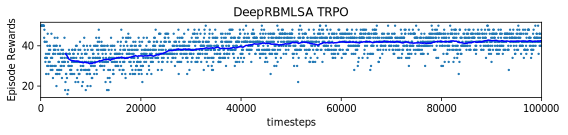

In [19]:
import matplotlib.pyplot as plt

results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DeepRBMLSA TRPO")
plt.savefig('deeprmsa_uniform.png')

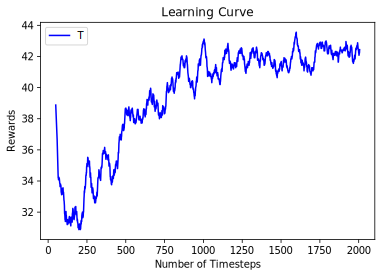

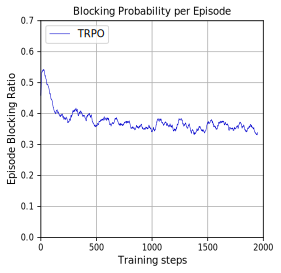

Mean blocking probability: 0.3749674837418709
Minimum blocking probability: 0.0
Maximun blocking probability: 0.66


In [18]:
import matplotlib.pyplot as plt

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results
    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'episodes')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y, color='BLUE')
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.gca().legend(('TRPO'))
    plt.title(title)
    plt.show()


plot_results(log_dir)

# Load the Pandas libraries with alias 'pd' 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./tmp/deeptest-ppo/training.monitor.csv')

stats = data.values  #stats[0] = 'episode_service_blocking_rate', 'episode_bit_rate_blocking_rate'
block_prob = stats[1:, [0]] #Selets only the blocking probability

lista = []

for i in range(len(block_prob)):
    lista.append(float(block_prob[i]))
    
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

y = moving_average(lista, 50)

f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(4, 4))

plt.plot(y, color="mediumblue", linestyle="-", linewidth=0.5, label="TRPO") # marker="o"

ax1.set_title('Blocking Probability per Episode', fontsize=10, fontweight='normal')
plt.legend(loc='upper left')
plt.xticks(fontsize=8,fontweight='normal')
plt.yticks(fontsize=8,fontweight='normal')
plt.xlabel('Training steps', fontsize=10)
plt.ylabel('Episode Blocking Ratio', fontsize=10)
plt.xlim(0, 2000)
plt.ylim(0, 0.7)
plt.grid(b=None, which='major', axis='both')
plt.savefig('Blocking Probability per Episode.png')
plt.show()

block_rate_mean = np.mean(lista)
block_rate_min = min(lista)
block_rate_max = max(lista)
print("Mean blocking probability:", block_rate_mean)
print("Minimum blocking probability:", block_rate_min)
print("Maximun blocking probability:", block_rate_max)